Bitcoin Trade Automation with Awesome Oscillator in Python
Implementing and backtesting an AO-based powerful trading strategy to make bitcoin trades in python

In [38]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [39]:
from google.colab import files
files.upload()

Saving BTC-USD.csv to BTC-USD (3).csv


{'BTC-USD.csv': b'Date,Open,High,Low,Close,Adj Close,Volume\n2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997\n2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465\n2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032\n2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275\n2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095\n2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598\n2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,8163.692383,28767291327\n2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,8079.862793,31672559265\n2020-01-09,8082.295898,8082.295898,7842.403809,7879.071289,7879.071289,24045990466\n2020-01-10,7878.307617,8166.554199,7726.774902,8166.554199,8166.554199,28714583844\n2020-01-11,8162.190918,8218.359375,8029.642090,8037.537598,8037.537598,25521165085\n2020-01-12,8033

In [40]:
btc = pd.read_csv('BTC-USD.csv')

In [41]:
btc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,1.856566e+10
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,2.080208e+10
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,2.811148e+10
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,1.844427e+10
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,1.972507e+10
...,...,...,...,...,...,...,...
491,2021-05-06,57441.308594,58363.316406,55382.507813,56396.515625,56396.515625,6.952329e+10
492,2021-05-07,56413.953125,58606.632813,55321.847656,57356.402344,57356.402344,6.843402e+10
493,2021-05-08,57352.765625,59464.613281,56975.210938,58803.777344,58803.777344,6.538298e+10
494,2021-05-09,58877.390625,59210.882813,56482.003906,58232.316406,58232.316406,6.590669e+10


In [42]:
btc.set_index(btc['Date'], drop=False, append=False, inplace=False, verify_integrity=False).drop('Date', 1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,1.856566e+10
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,2.080208e+10
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,2.811148e+10
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,1.844427e+10
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,1.972507e+10
...,...,...,...,...,...,...
2021-05-06,57441.308594,58363.316406,55382.507813,56396.515625,56396.515625,6.952329e+10
2021-05-07,56413.953125,58606.632813,55321.847656,57356.402344,57356.402344,6.843402e+10
2021-05-08,57352.765625,59464.613281,56975.210938,58803.777344,58803.777344,6.538298e+10


In [43]:
def sma(price, period):
    sma = price.rolling(period).mean()
    return sma

def ao(price, period1, period2):
    median = price.rolling(2).median()
    short = sma(median, period1)
    long = sma(median, period2)
    ao = short - long
    ao_df = pd.DataFrame(ao).rename(columns = {'Close':'ao'})
    return ao_df

btc['ao'] = ao(btc['Close'], 5, 34)
btc = btc.dropna()
btc.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,ao
491,2021-05-06,57441.308594,58363.316406,55382.507813,56396.515625,56396.515625,6.952329e+10,-660.608686
492,2021-05-07,56413.953125,58606.632813,55321.847656,57356.402344,57356.402344,6.843402e+10,-683.652056
493,2021-05-08,57352.765625,59464.613281,56975.210938,58803.777344,58803.777344,6.538298e+10,-447.796702
494,2021-05-09,58877.390625,59210.882813,56482.003906,58232.316406,58232.316406,6.590669e+10,213.905055
495,2021-05-10,58250.871094,59519.355469,54071.457031,55859.796875,55859.796875,7.177655e+10,593.804710


Text(0.5, 1.0, 'BITCOIN CLOSING PRICE')

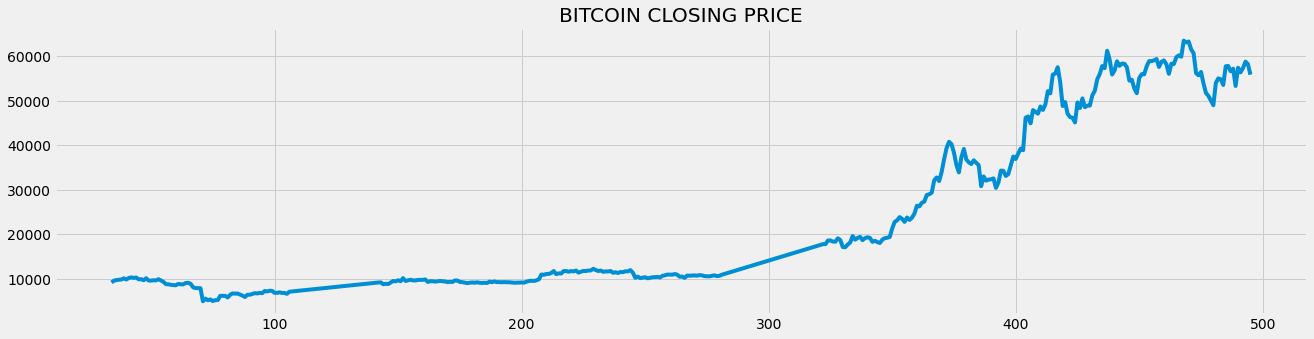

In [44]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax1.plot(btc['Close'])
ax1.set_title('BITCOIN CLOSING PRICE')

In [45]:
def implement_ao_crossover(price, ao):
    buy_price = []
    sell_price = []
    ao_signal = []
    signal = 0
    
    for i in range(len(ao)):
        if ao[i] > 0 and ao[i-1] < 0:
            if signal != 1:
                buy_price.append(price[i])
                sell_price.append(np.nan)
                signal = 1
                ao_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ao_signal.append(0)
        elif ao[i] < 0 and ao[i-1] > 0:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(price[i])
                signal = -1
                ao_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ao_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            ao_signal.append(0)
    return buy_price, sell_price, ao_signal

buy_price, sell_price, ao_signal = implement_ao_crossover(btc['Close'], btc['ao'])

KeyError: ignored